In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import unyt
from cholla_cooling import ChollaEOS
from estimate_survival_radius import estimate_survival_radius

def tcool_from_rhoT(rho, T, eos):
    gm1 = eos.get_gamma() - 1
    eint = unyt.kboltz_cgs * T.flatten()/(0.6 * unyt.mh_cgs * gm1)
    print(cholla_cie_eos.calculate_T(rho.flatten(), eint))
    out = cholla_cie_eos.calculate_tcool(rho.flatten(), eint)
    out.shape = rho.shape
    return out

# by ommitting cloudy_data_path, we initialize the CIE cooling function
cholla_cie_eos = ChollaEOS(
    #cloudy_data_path = ('/home/mabruzzo/hydro/cholla/src/cooling/'
    #                    'cloudy_coolingcurve.txt')
)

rho_vals = unyt.unyt_array(np.geomspace(1e-28, 10**-22.5, num = 5001), 'g/cm**3')
T_vals = unyt.unyt_array(np.geomspace(10**3.5, 10**8.5, num = 5001), 'K')
Rho, T = np.meshgrid(rho_vals, T_vals)

tcool = tcool_from_rhoT(Rho, T, eos = cholla_cie_eos)

[3.16015333e+03 3.16015333e+03 3.16015333e+03 ... 3.16015333e+08
 3.16015333e+08 3.16015333e+08] K


In [2]:
def calc_tsputter(rho, T, a = unyt.unyt_quantity(0.1, 'um')):
    coef = 0.17 * unyt.Gyr
    omega = 2.5
    return (
        coef * 
        (a/ unyt.unyt_quantity(0.1, 'um')) *
        (unyt.unyt_quantity(1e-27, 'g/cm**3')/ rho) *
        (1 + (10**6.3 * unyt.K / T)**omega)
    )

Gyr


/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


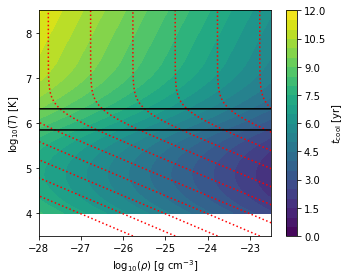

In [3]:

tsputter = calc_tsputter(Rho, T)
print(tsputter.units)

fig, ax = plt.subplots(1,1, figsize = (5,4))

# Plot the filled contours corresponding for different cooling times
CS = ax.contourf(
    np.log10(Rho.ndview), np.log10(T.ndview),
    np.log10(-1*tcool.to('year').ndview),
    levels = np.arange(25) / 2.0,
)

# Plot the tsputter contours
tmp = ax.contour(
    np.log10(Rho.ndview), np.log10(T.ndview),
    np.log10(tsputter.to('year').ndview),
    levels = [4,5,6,7,8,9,10,11,12,13,14],
    colors = 'r', linestyles = 'dotted'
)

# plots the horizontal black lines that correspond to the locations where 
# the rato between tsputter/tcool has particular values
tmp = ax.contour(
    np.log10(Rho.ndview), np.log10(T.ndview),
    np.log10(-1 * (tsputter/tcool).to('dimensionless').ndview),
    levels = [0,2],
    colors = 'k'
)
ax.set_xlabel(r'$\log_{10}(\rho)$ [${\rm g}\ {\rm cm}^{-3}$]')
ax.set_ylabel(r'$\log_{10}(T)$ [K]')
fig.colorbar(CS, label = r'$t_{\rm cool}$ [yr]')
fig.tight_layout()
plt.savefig('tsputter-vs-tcool_tenthmicron.pdf')

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


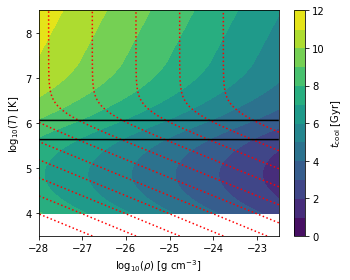

In [4]:

tsputter = calc_tsputter(Rho, T,
                         a = unyt.unyt_quantity(0.01, 'um'))

fig, ax = plt.subplots(1,1, figsize = (5,4))

# Plot the filled contours corresponding for different cooling times
CS = ax.contourf(
    np.log10(Rho.ndview), np.log10(T.ndview),
    np.log10(-1*tcool.to('year').ndview),
    levels = [0, 1,2,3,4,5,6,7,8,9, 10, 11, 12],
    #colors = 'k'
)


# Plot the tsputter contours
tmp = ax.contour(
    np.log10(Rho.ndview), np.log10(T.ndview),
    np.log10(tsputter.to('year').ndview),
    levels = [4,5,6,7,8,9,10,11,12,13,14],
    colors = 'r', linestyles = 'dotted'
)

# plots the horizontal black lines that correspond to the locations where 
# the rato between tsputter/tcool has particular values
tmp = ax.contour(
    np.log10(Rho.ndview), np.log10(T.ndview),
    np.log10(-1 * (tsputter/tcool).to('dimensionless').ndview),
    levels = [0,2],
    colors = 'k'
)
ax.set_xlabel(r'$\log_{10}(\rho)$ [${\rm g}\ {\rm cm}^{-3}$]')
ax.set_ylabel(r'$\log_{10}(T)$ [K]')
fig.colorbar(CS, label = r'$t_{\rm cool}$ [Gyr]')
fig.tight_layout()
plt.savefig('tsputter-vs-tcool_hundrethmicron.pdf')

(1e-07, 61.43215219258667)

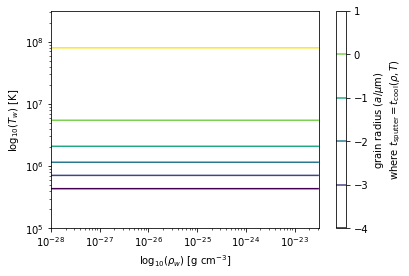

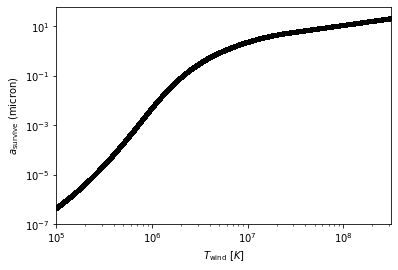

In [5]:
# Here we plot a_survive
# -> for a given wind temperature, a_survive is the dust 
#    radius for which t_sputter == t_cool,w (it's remarkably
#    pressure-independent)
# -> any dust grain larger than a_survive has a sputtering time
#    longer than t_cool,w. Thus the wind starts to cool. Since
#    a cooling wind will take longer and longer to sputter dust,
#    dust grains larger than t_cool,w can't be effectively destroyed

def calc_survival_grain_radius(rho, T, eos, alpha = 1):
    omega = 2.5
    coef = 0.17 * unyt.Gyr
    tmp = (
        coef *
        (unyt.unyt_quantity(1e-27, 'g/cm**3')/ rho) *
        (1 + (10**6.3 * unyt.K / T)**omega)
    )
    gm1 = eos.get_gamma() - 1
    Eint = unyt.kboltz_cgs * T/(0.6 * unyt.mh_cgs * gm1)
    tcool = -1*eos.calculate_tcool(rho.flatten(), Eint.flatten())
    tcool.shape = rho.shape
    return 0.1*unyt.um* tcool/tmp

a_min = calc_survival_grain_radius(Rho, T, cholla_cie_eos)

fig,ax = plt.subplots(1,1)
im = ax.contour(Rho, T, np.log10(a_min.to('um').ndview),
                levels = [-4,-3,-2,-1, 0, 1])

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e5, 10**8.5)
ax.set_xlabel(r'$\log_{10}(\rho_w)$ [${\rm g}\ {\rm cm}^{-3}$]')
ax.set_ylabel(r'$\log_{10}(T_w)$ [${\rm K}$]')

fig.colorbar(im, 
             label = (r'grain radius $(a / \mu {\rm m})$' + '\n'
                      r'where $t_{\rm sputter} = t_{\rm cool}(\rho,T)$')
            )


fig,ax = plt.subplots(1,1)

ax.plot(T.flatten(), a_min.to('um').ndview.flatten(), 'k.')
ax.set_xlabel(r'$T_{\rm wind}$ [$K$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$a_{\rm survive}$ (micron)')
ax.set_xlim(1e5, 10**8.5)
ax.set_ylim(1e-7, ax.get_ylim()[1])

